In [ ]:
#############################################
#          Preprocessing Definition         #
#############################################

import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split


# --------------------------
# Resizing and Padding Classes
# --------------------------

class ResizeWithPadding:
    """
    For color images. Uses bilinear interpolation.
    """
    def __init__(self, target_size=512, padding_mode='mean', force_resize=True, resize_dims=(128, 128)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims
        assert padding_mode in ['mean', 'reflect', 'hybrid'], \
            "Padding mode must be 'mean', 'reflect', or 'hybrid'"
        self.padding_mode = padding_mode

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        return resized_image

    def pad_image(self, image):
        h, w = image.shape[:2]
        # Determine target dimensions
        target_h, target_w = self.resize_dims if self.force_resize else (self.target_size, self.target_size)
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left

        if self.padding_mode == 'mean':
            mean_pixel = np.mean(image, axis=(0, 1), dtype=int)
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        elif self.padding_mode == 'reflect':
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
        else:  # hybrid
            reflected = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
            mean_pixel = np.mean(image, axis=(0, 1), dtype=int)
            padded_image = cv2.copyMakeBorder(reflected, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        return padded_image

    def __call__(self, img):
        # Convert PIL image to numpy array, process, and convert back
        arr = np.array(img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

class ResizeWithPaddingLabel:
    """
    For labels/masks. Uses nearest-neighbor interpolation.
    Assumes labels are single-channel images.
    """
    def __init__(self, target_size=512, force_resize=False, resize_dims=(256, 256)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        return resized_image

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = self.resize_dims if self.force_resize else (self.target_size, self.target_size)
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        # For labels, use a constant value (e.g., 0 for background)
        padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                          cv2.BORDER_CONSTANT, value=0)
        return padded_image

    def __call__(self, label_img):
        arr = np.array(label_img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

# --------------------------
# Augmentation Function for Synchronized Transforms
# --------------------------

def elastic_transform_pair(image, label, alpha=34, sigma=4):
    """Apply elastic transformation to both image and label."""
    np_img = np.array(image)
    np_label = np.array(label)
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]
    dx = (random_state.rand(*shape) * 2 - 1)
    dy = (random_state.rand(*shape) * 2 - 1)
    dx = cv2.GaussianBlur(dx, (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (17, 17), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)
    transformed_img = cv2.remap(np_img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    transformed_label = cv2.remap(np_label, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return Image.fromarray(transformed_img), Image.fromarray(transformed_label)

def augment_pair(image, label, size=(256, 256), apply_color=True, **params):
    """
    Applies a random subset of augmentations in random order.
    Each augmentation is stored as a function with its own probability.

    To disable an augmentation, set its probability to 0.
    To guarantee an augmentation, set its probability to 1.
    Modify parameters (e.g., rotation_angle, translate_factor) to adjust intensity.
    """
    # Build list of augmentation functions with their associated probability.
    augmentations = []

    # Horizontal flip
    augmentations.append((
        lambda img, lbl: (F.hflip(img), F.hflip(lbl)),
        params.get("flip_prob", 0.5)  # default: 50% chance
    ))

    # Rotation (you can control intensity via "rotation_angle")
    def rotate_aug(img, lbl):
        angle = random.uniform(-params.get("rotation_angle", 5), params.get("rotation_angle", 45))
        return F.rotate(img, angle, interpolation=Image.BILINEAR), F.rotate(lbl, angle, interpolation=Image.NEAREST)
    augmentations.append((
        rotate_aug,
        params.get("rotation_prob", 0.25)  # default: always apply rotation
    ))

    # Translation (intensity via "translate_factor")
    def translate_aug(img, lbl):
        max_translate = params.get("translate_factor", 0.05) * size[0]
        tx = int(random.uniform(-max_translate, max_translate))
        ty = int(random.uniform(-max_translate, max_translate))
        return (F.affine(img, angle=0, translate=(tx, ty), scale=1.0, shear=0, interpolation=Image.BILINEAR),
                F.affine(lbl, angle=0, translate=(tx, ty), scale=1.0, shear=0, interpolation=Image.NEAREST))
    augmentations.append((
        translate_aug,
        params.get("translate_prob", 0.05)  # default: always apply translation
    ))

    # Random Resized Crop (controls framing; intensity via crop_scale_range and crop_ratio_range)
    def crop_aug(img, lbl):
        i, j, h, w = transforms.RandomResizedCrop.get_params(
            img,
            scale=params.get("crop_scale_range", (0.9, 1.0)),
            ratio=params.get("crop_ratio_range", (1.0, 1.0))
        )
        return (F.resized_crop(img, i, j, h, w, size, interpolation=Image.BILINEAR),
                F.resized_crop(lbl, i, j, h, w, size, interpolation=Image.NEAREST))
    augmentations.append((
        crop_aug,
        params.get("crop_prob", 0.01)  # default: always apply crop
    ))

    # Elastic Transformation (intensity via "elastic_alpha" and "elastic_sigma")
    def elastic_aug(img, lbl):
        return elastic_transform_pair(
            img, lbl,
            alpha=params.get("elastic_alpha", 15),
            sigma=params.get("elastic_sigma", 2)
        )
    augmentations.append((
        elastic_aug,
        params.get("elastic_prob", 0.01)  # default: always apply elastic transformation
    ))

    # Random Scaling (intensity via "scaling_range")
    def scaling_aug(img, lbl):
        scale_factor = random.uniform(*params.get("scaling_range", (0.0, 0.0)))
        new_size = (int(size[0] * scale_factor), int(size[1] * scale_factor))
        return (F.resize(img, new_size, interpolation=Image.BILINEAR),
                F.resize(lbl, new_size, interpolation=Image.NEAREST))
    augmentations.append((
        scaling_aug,
        params.get("scaling_prob", 0.0)  # default: always apply scaling
    ))

    # Color augmentations: Gaussian blur and Color jitter.
    def color_aug(img, lbl):
        if random.random() < params.get("blur_prob", 0.0):
            img = img.filter(
                ImageFilter.GaussianBlur(
                    radius=random.uniform(*params.get("blur_radius_range", (0.5, 1.5)))
                )
            )
        color_jitter = transforms.ColorJitter(**params.get("color_jitter_params", {
            'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2, 'hue': 0.1
        }))
        img = color_jitter(img)
        return img, lbl
    augmentations.append((
        color_aug,
        params.get("color_prob", 0.25)  # default: always apply color adjustments if apply_color is True
    ))

    # Optionally randomize the order of augmentations.
    random.shuffle(augmentations)

    # Apply each augmentation based on its probability.
    for func, prob in augmentations:
        if random.random() < prob:
            image, label = func(image, label)

    # Optionally, enforce a final center crop to ensure the image is the desired size.
    image = F.center_crop(image, size)
    label = F.center_crop(label, size)

    return image, label

# --------------------------
# OOP Preprocessor Class
# --------------------------

class Preprocessor:
    def __init__(self, raw_color_path, raw_label_path,
                 proc_color_path, proc_label_path,
                 resize_dim=128, do_augmentation=True,
                 is_train=True, max_images=None, aug_count=10, aug_params=None):

        """
        Parameters:
          - raw_color_path: Relative path to raw color images.
          - raw_label_path: Relative path to raw label/mask images.
          - proc_color_path: Relative path to save processed color images.
          - proc_label_path: Relative path to save processed label images.
          - resize_dim: Target dimension for resizing/padding.
          - do_augmentation: Whether to augment (only for training).
          - is_train: True if processing training data.
          - max_images: Process only a subset of images (for testing the pipeline).
          - aug_count: Number of augmentations to create per image (train only).
        """
        self.aug_params = aug_params if aug_params is not None else {}

        self.raw_color_path = Path(raw_color_path)
        self.raw_label_path = Path(raw_label_path)
        self.proc_color_path = Path(proc_color_path)
        self.proc_label_path = Path(proc_label_path)
        self.resize_dim = resize_dim
        self.do_augmentation = do_augmentation and is_train
        self.is_train = is_train
        self.max_images = max_images
        self.aug_count = aug_count

        self.proc_color_path.mkdir(parents=True, exist_ok=True)
        self.proc_label_path.mkdir(parents=True, exist_ok=True)

        # Create transforms for images and labels
        self.transform_img = ResizeWithPadding(target_size=224, padding_mode='mean',
                                               force_resize=True, resize_dims=(resize_dim, resize_dim))
        self.transform_label = ResizeWithPaddingLabel(target_size=224, force_resize=True,
                                                      resize_dims=(resize_dim, resize_dim))

    def process(self):
        # Find all color images (assume image file names match label file names)
        image_extensions = (".jpg", ".jpeg", ".png")
        image_files = [f for f in self.raw_color_path.rglob("*") if f.suffix.lower() in image_extensions]
        if self.max_images is not None:
            image_files = image_files[:self.max_images]

        if not image_files:
            print("❌ No images found in", self.raw_color_path)
            return

        for img_file in image_files:
            label_file = self.raw_label_path / f"{img_file.stem}.png"
            if not label_file.exists():
                print(f"⚠️  Label for {img_file.name} not found, skipping.")
                continue

            # Open image and label (assume label is a segmentation mask in grayscale)
            img = Image.open(img_file).convert("RGB")
            label = Image.open(label_file).convert("L")

            # Apply resizing and padding to both image and label
            proc_img = self.transform_img(img)
            proc_label = self.transform_label(label)

            # Save processed (base) image and label
            proc_img.save(self.proc_color_path / f"processed_{img_file.name}")
            proc_label.save(self.proc_label_path / f"processed_{label_file.name}")
            print(f"Processed {img_file.name}")

            # If training and augmentation is enabled, create additional augmented pairs
            if self.is_train and self.do_augmentation:
                for i in range(self.aug_count):
                    aug_img, aug_label = augment_pair(proc_img, proc_label, size=(self.resize_dim, self.resize_dim), **self.aug_params)
                    aug_img.save(self.proc_color_path / f"processed_{img_file.stem}_aug_{i}{img_file.suffix}")
                    aug_label.save(self.proc_label_path / f"processed_{label_file.stem}_aug_{i}{label_file.suffix}")
                    print(f"Augmented {img_file.name} -> aug {i}")

# --------------------------
# Command Line Interface
# --------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Preprocess train/test images with labels/masks using relative paths."
    )
    parser.add_argument("--raw_color", type=str, required=True, default='raw/TrainVal/color',
                        help="Relative path to raw color images (e.g., Dataset/raw/TrainVal/color).")
    parser.add_argument("--raw_label", type=str, required=True, default='raw/TrainVal/label',
                        help="Relative path to raw label images (e.g., Dataset/raw/TrainVal/label).")
    parser.add_argument("--proc_color", type=str, required=True, default='Dataset/processed/TrainVal/color',
                        help="Relative path to save processed color images (e.g., Dataset/processed/TrainVal/color).")
    parser.add_argument("--proc_label", type=str, required=True, default='Dataset/processed/TrainVal/label',
                        help="Relative path to save processed label images (e.g., Dataset/processed/TrainVal/label).")
    parser.add_argument("--resize_dim", type=int, default=128,
                        help="Output dimension for resizing (e.g., 128 or 256).")
    parser.add_argument("--no_augment", action="store_true",
                        help="Disable augmentation (for test sets).")
    parser.add_argument("--max_images", type=int, default=None,
                        help="Process only a subset of images (default: all).")
    parser.add_argument("--aug_count", type=int, default=10,
                        help="Number of augmentations per image (train only).")
    parser.add_argument("--set_type", type=str, choices=["TrainVal", "Test"], default="TrainVal",
                        help="Dataset type: TrainVal or Test.")
    parser.add_argument("--flip_prob", type=float, default=0.5, help="Probability for horizontal flip.")
    parser.add_argument("--rotation_angle", type=float, default=5, help="Maximum rotation angle (in degrees).")
    parser.add_argument("--translate_factor", type=float, default=0.05, help="Translation factor (fraction of image size).")
    parser.add_argument("--crop_scale_min", type=float, default=0.9, help="Minimum scale for random resized crop.")
    parser.add_argument("--crop_scale_max", type=float, default=1.0, help="Maximum scale for random resized crop.")
    parser.add_argument("--crop_ratio_min", type=float, default=1.0, help="Minimum aspect ratio for random resized crop.")
    parser.add_argument("--crop_ratio_max", type=float, default=1.0, help="Maximum aspect ratio for random resized crop.")
    parser.add_argument("--elastic_alpha", type=float, default=15, help="Elastic transformation alpha parameter.")
    parser.add_argument("--elastic_sigma", type=float, default=2, help="Elastic transformation sigma parameter.")
    parser.add_argument("--scaling_min", type=float, default=0.0, help="Minimum scaling factor for random scaling.")
    parser.add_argument("--scaling_max", type=float, default=0.0, help="Maximum scaling factor for random scaling.")
    parser.add_argument("--blur_prob", type=float, default=0.3, help="Probability of applying Gaussian blur.")
    parser.add_argument("--blur_radius_min", type=float, default=0.5, help="Minimum radius for Gaussian blur.")
    parser.add_argument("--blur_radius_max", type=float, default=1.5, help="Maximum radius for Gaussian blur.")
    parser.add_argument("--color_jitter_brightness", type=float, default=0.2, help="Brightness for color jitter.")
    parser.add_argument("--color_jitter_contrast", type=float, default=0.2, help="Contrast for color jitter.")
    parser.add_argument("--color_jitter_saturation", type=float, default=0.2, help="Saturation for color jitter.")
    parser.add_argument("--color_jitter_hue", type=float, default=0.1, help="Hue for color jitter.")

    ## Test processing (resizing)
    sys.argv = ['preprocessing.py', '--raw_color', '/content/raw/Test/color',
                '--raw_label', '/content/raw/Test/label',
                '--proc_color', '/content/processed/Test/color',
                '--proc_label', '/content/processed/Test/label',
                '--resize_dim', '128',
                '--no_augment',
                '--set_type', 'Test']

    ## TrainVal augmentation
    sys.argv = ['preprocessing.py',
                '--raw_color', '/content/raw/TrainVal/color',
                '--raw_label', '/content/raw/TrainVal/label',
                '--proc_color', '/content/processed/TrainVal/color',
                '--proc_label', '/content/processed/TrainVal/label',
                '--resize_dim', '128',
                '--aug_count', '10',
                '--set_type', 'TrainVal',
                '--translate_factor', '0.02',
                '--elastic_alpha', '0.0',
                '--elastic_sigma', '0.05',
                '--blur_radius_min', '0.0',
                '--blur_radius_max', '0.05']

    args = parser.parse_args()

    # Define relative paths based on set type
    if args.set_type == "TrainVal":
        raw_color = Path("/content/raw/TrainVal/color")
        raw_label = Path("/content/raw/TrainVal/label")
        proc_color = Path("/content/processed/TrainVal/color")
        proc_label = Path("/content/processed/TrainVal/label")
    else:  # Test set
        raw_color = Path("/content/raw/Test/color")
        raw_label = Path("/content/raw/Test/label")
        proc_color = Path("/content/processed/Test/color")
        proc_label = Path("/content/processed/Test/label")

    aug_params = {
        "flip_prob": args.flip_prob,  # Already exists.
        "rotation_angle": args.rotation_angle,
        "rotation_prob": 0.25,         # Always apply rotation, for instance.
        "translate_factor": args.translate_factor,
        "translate_prob": 0.05,        # Always apply translation.
        "crop_scale_range": (args.crop_scale_min, args.crop_scale_max),
        "crop_ratio_range": (args.crop_ratio_min, args.crop_ratio_max),
        "crop_prob": 0.01,             # Always apply crop.
        "elastic_alpha": args.elastic_alpha,
        "elastic_sigma": args.elastic_sigma,
        "elastic_prob": 0.01,          # Always apply elastic transform.
        "scaling_range": (0.8, 1.2),
        "scaling_prob": 0.05,          # Always apply scaling.
        "blur_prob": args.blur_prob,
        "blur_radius_range": (args.blur_radius_min, args.blur_radius_max),
        "color_jitter_params": {
            "brightness": args.color_jitter_brightness,
            "contrast": args.color_jitter_contrast,
            "saturation": args.color_jitter_saturation,
            "hue": args.color_jitter_hue,
        },
        "color_prob": 1.0            # Always apply color adjustments if enabled.
    }

    preprocessor = Preprocessor(raw_color, raw_label,
                                proc_color, proc_label,
                                resize_dim=args.resize_dim,
                                do_augmentation=not args.no_augment,
                                is_train=(args.set_type == "TrainVal"),
                                max_images=args.max_images,
                                aug_count=args.aug_count,
                                aug_params=aug_params)

    preprocessor.process()

In [ ]:
import os
import time
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#############################################
# 1. Dataset Classes
#############################################
class SegmentationDataset(Dataset):
    """
    A simple dataset for image segmentation.
    Assumes:
      - root_dir/color contains the RGB images.
      - root_dir/label contains corresponding segmentation masks.
      - Each label image has the same stem as its corresponding color image (with a .png extension).
    """
    def __init__(self, root_dir, transform_img=None, transform_label=None):
        self.root_dir = Path(root_dir)
        self.color_dir = self.root_dir / "color"
        self.label_dir = self.root_dir / "label"
        self.transform_img = transform_img
        self.transform_label = transform_label

        self.image_files = sorted([
            f for f in self.color_dir.iterdir()
            if f.is_file() and f.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        label_path = self.label_dir / (img_path.stem + ".png")
        label = Image.open(label_path).convert("L")  # grayscale

        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)

        label_np = np.array(label, dtype=np.int64)
        # Mapping: 0 stays 0; 38 or 75 become 1; 255 becomes 2.
        label_new = np.zeros_like(label_np)
        label_new[label_np == 38] = 1
        label_new[label_np == 75] = 1
        label_new[label_np == 255] = 2
        label_tensor = torch.from_numpy(label_new).long()
        if self.transform_label:
            label_tensor = self.transform_label(label_tensor)

        return image, label_tensor

class SegmentationDatasetWithText(Dataset):
    """
    Extends SegmentationDataset to also return token IDs extracted from the filename.
    """
    def __init__(self, root_dir, vocab, max_tokens=2, transform_img=None, transform_label=None):
        self.root_dir = Path(root_dir)
        self.color_dir = self.root_dir / "color"
        self.label_dir = self.root_dir / "label"
        self.vocab = vocab
        self.max_tokens = max_tokens
        self.transform_img = transform_img
        self.transform_label = transform_label

        self.image_files = sorted([
            f for f in self.color_dir.iterdir()
            if f.is_file() and f.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])

    def tokenize_filename(self, filename):
      base = filename.rsplit(".", 1)[0]
      tokens = base.split("_")
      animal_type = tokens[0].lower()
      # Combine breed tokens until a numeric token is encountered.
      breed_tokens = []
      for tok in tokens[1:]:
          if tok.isdigit():
              break
          breed_tokens.append(tok.lower())
      breed_name = "_".join(breed_tokens)

      # Lookup both tokens.
      token_ids = [self.vocab.get(animal_type, 0), self.vocab.get(breed_name, 0)]

      # Pad or trim the list to max_tokens.
      if len(token_ids) < self.max_tokens:
          token_ids += [0] * (self.max_tokens - len(token_ids))
      else:
          token_ids = token_ids[:self.max_tokens]
      return token_ids

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        label_path = self.label_dir / (img_path.stem + ".png")
        label = Image.open(label_path).convert("L")

        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)

        label_np = np.array(label, dtype=np.int64)
        label_new = np.zeros_like(label_np)
        label_new[label_np == 38] = 1
        label_new[label_np == 75] = 1
        label_new[label_np == 255] = 2
        label_tensor = torch.from_numpy(label_new).long()
        if self.transform_label:
            label_tensor = self.transform_label(label_tensor)

        token_ids = self.tokenize_filename(img_path.name)
        token_ids_tensor = torch.tensor(token_ids, dtype=torch.long)

        return image, label_tensor, token_ids_tensor

#############################################
# 2. Vocabulary Building
#############################################
def build_vocabulary(all_files):
    all_tokens = set()

    for filename in all_files:
        base = filename.rsplit(".", 1)[0]  # Remove file extension

        tokens = base.split("_")
        animal_type = tokens[0].lower()  # First token is always 'cat' or 'dog'

        # Extract breed name (all words before reaching a number token)
        breed_tokens = []
        for tok in tokens[1:]:  # Start after animal type
            if tok.isdigit():  # Stop at the first number
                break
            breed_tokens.append(tok.lower())  # Keep breed name words

        breed_name = "_".join(breed_tokens)  # Join multi-word breeds with '_'

        # Add tokens to vocabulary
        all_tokens.add(animal_type)
        all_tokens.add(breed_name)

    # Create vocabulary mapping
    vocab = {}
    idx = 1  # Reserve index 0 for padding
    for t in sorted(all_tokens):
        vocab[t] = idx
        idx += 1

    return vocab

# Build vocabulary from TrainVal/color directory.
path = '/Dataset/processed/TrainVal/color'
color_files = os.listdir(path)
vocab = build_vocabulary(color_files)
print("Vocabulary size:", len(vocab)+1)
print("Vocabulary:", vocab)

#############################################
# 3. Model Components
#############################################

# 3a. Image Encoder (CNN) with Dropout
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.25):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_prob)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        shortcut = self.shortcut(x)
        out += shortcut
        out = self.relu(out)
        return out


class ImprovedCNNEncoderForSeg(nn.Module):
    def __init__(self, output_channels=512, dropout_prob=0.25):
        super(ImprovedCNNEncoderForSeg, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # [B, 64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = ResidualBlock(64, 64, stride=1, dropout_prob=dropout_prob)   # [B, 64, 64, 64]
        self.layer2 = ResidualBlock(64, 128, stride=2, dropout_prob=dropout_prob)  # [B, 128, 32, 32]
        self.layer3 = ResidualBlock(128, 256, stride=2, dropout_prob=dropout_prob)  # [B, 256, 16, 16]
        self.layer4 = ResidualBlock(256, output_channels, stride=1, dropout_prob=dropout_prob)  # [B, output_channels, 16, 16]

    def forward(self, x):
        x = self.initial(x)
        skip_feature = self.layer1(x)  # Save skip feature
        x = self.layer2(skip_feature)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, skip_feature

# 3b. Text Encoder
class ImprovedTextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, output_dim=512, dropout_prob=0.1):
        super(ImprovedTextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, token_ids):
        embeds = self.embedding(token_ids)   # [B, seq_length, embed_dim]
        embeds = self.dropout(embeds)
        pooled = embeds.mean(dim=1)            # [B, embed_dim]
        hidden = self.fc1(pooled)              # [B, hidden_dim]
        hidden = self.act(hidden)
        hidden = self.dropout(hidden)
        out = self.fc2(hidden)                 # [B, output_dim]
        out = self.layer_norm(out)
        out = out / (out.norm(dim=-1, keepdim=True) + 1e-6)
        return out

# 3c. Fusion and Segmentation Head
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ImprovedCLIPSegmentationHead(nn.Module):
    def __init__(self, in_channels, text_dim, num_classes, dropout_prob=0.25, use_attention=True):
        super(ImprovedCLIPSegmentationHead, self).__init__()
        self.text_proj = nn.Linear(text_dim, in_channels)

        self.fuse_conv1 = nn.Sequential(
            nn.Conv2d(in_channels * 2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )

        self.residual_block = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
        )
        self.relu = nn.ReLU(inplace=True)

        if use_attention:
            self.attention = ChannelAttention(256)
        else:
            self.attention = nn.Identity()

        self.fuse_conv2 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, img_features, text_features):
        B, C, H, W = img_features.shape
        projected_text = self.text_proj(text_features)  # [B, in_channels]
        projected_text = projected_text.view(B, C, 1, 1).expand(B, C, H, W)
        fused = torch.cat([img_features, projected_text], dim=1)  # [B, 2*C, H, W]
        x = self.fuse_conv1(fused)  # [B, 256, H, W]
        res = self.residual_block(x)
        x = self.relu(x + res)
        x = self.attention(x)
        logits = self.fuse_conv2(x)  # [B, num_classes, H, W]
        return logits

# 3d. Combined CLIP-Segmentation Model
class ImprovedCLIPSegmentationModel(nn.Module):
    def __init__(self, vocab_size, text_embed_dim=128, text_output_dim=512,
                 image_embed_channels=512, num_classes=3, dropout_prob=0.25):
        super(ImprovedCLIPSegmentationModel, self).__init__()
        self.image_encoder = ImprovedCNNEncoderForSeg(output_channels=image_embed_channels, dropout_prob=dropout_prob)
        self.text_encoder = ImprovedTextEncoder(vocab_size, embed_dim=text_embed_dim, hidden_dim=256, output_dim=text_output_dim, dropout_prob=0.1)
        self.seg_head = ImprovedCLIPSegmentationHead(in_channels=image_embed_channels, text_dim=text_output_dim,
                                                     num_classes=num_classes, dropout_prob=dropout_prob)
        # Final skip connection from low‐level image features.
        # Remove the extra upsampling here.
        self.skip_proj = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, image, token_ids):
        # image: [B, 3, 128, 128]; token_ids: [B, 5]
        img_features, skip_feature = self.image_encoder(image)  # img_features: [B, 512, 16, 16], skip_feature: [B, 64, 64, 64]
        text_features = self.text_encoder(token_ids)            # [B, 512]
        seg_logits = self.seg_head(img_features, text_features)   # [B, num_classes, 16, 16]
        seg_logits = F.interpolate(seg_logits, size=(128, 128), mode="bilinear", align_corners=False)
        # Upsample the skip_feature to 128x128 and project it to num_classes.
        skip_feature_up = F.interpolate(skip_feature, size=(128,128), mode="bilinear", align_corners=False)
        skip_logits = self.skip_proj(skip_feature_up)  # Now: [B, num_classes, 128, 128]
        out_logits = seg_logits + skip_logits
        return out_logits


#############################################
# 4. Training and Evaluation Setup
#############################################
def compute_iou(preds, targets, num_classes=3):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

def pixel_accuracy(output, target):
    _, preds = torch.max(output, dim=1)
    correct = (preds == target).float().sum()
    return correct / torch.numel(target)

FileNotFoundError: [Errno 2] No such file or directory: '/content/processed/TrainVal/color'

In [ ]:
#######################################################
# Training Loop with Early Stopping and Visualization #
#######################################################
def train_real_model(epochs=100, batch_size=16, patience=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transforms.
    transform_img = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
    ])
    transform_label = None

    # Create dataset (for training, use TrainVal folder)
    train_dataset = SegmentationDatasetWithText(
        root_dir='/content/processed/TrainVal',
        vocab=vocab,
        max_tokens=2,
        transform_img=transform_img,
        transform_label=transform_label
    )
    # For simplicity, use 80% for training and 20% for validation.
    indices = list(range(len(train_dataset)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_set = Subset(train_dataset, train_idx)
    val_set = Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Instantiate model.
    model = ImprovedCLIPSegmentationModel(vocab_size=len(vocab)+1, text_embed_dim=128, text_output_dim=512,
                                  image_embed_channels=512, num_classes=3, dropout_prob=0.25).to(device)

    for param in model.image_encoder.parameters():
        param.requires_grad = False
    for param in model.text_encoder.parameters():
        param.requires_grad = False

    criterion = nn.CrossEntropyLoss()  # segmentation loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_loss = float('inf')
    best_model_path = "clip_segmentation_best.pth"
    metrics = []

    overall_start = time.time()
    patience_counter = 0

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_pixels = 0
        epoch_start = time.time()

        for batch_idx, (images, masks, token_ids) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            token_ids = token_ids.to(device)

            optimizer.zero_grad()
            seg_logits = model(images, token_ids)  # [B, 3, 128, 128]
            loss = criterion(seg_logits, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(seg_logits, dim=1)
            running_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

            # Timer per batch.
            elapsed = time.time() - epoch_start
            progress = (batch_idx + 1) / len(train_loader)
            eta = elapsed / progress - elapsed
            print(f"\rEpoch {epoch}/{epochs} - Batch {batch_idx+1}/{len(train_loader)}: Loss: {loss.item():.4f}, ETA: {eta:.2f}s", end="")
        print()

        train_loss = running_loss / len(train_set)
        train_acc = running_correct / total_pixels

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_pixels = 0
        all_val_preds = []
        all_val_masks = []
        with torch.no_grad():
            for images, masks, token_ids in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                token_ids = token_ids.to(device)
                outputs = model(images, token_ids)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == masks).sum().item()
                val_pixels += torch.numel(masks)
                all_val_preds.append(preds.cpu())
                all_val_masks.append(masks.cpu())

        val_loss = val_loss / len(val_set)
        val_acc = val_correct / val_pixels
        all_val_preds = torch.cat(all_val_preds, dim=0)
        all_val_masks = torch.cat(all_val_masks, dim=0)
        iou = compute_iou(all_val_preds, all_val_masks, num_classes=3)
        avg_iou = np.nanmean(iou)

        print(f"Epoch {epoch} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val IoU: {avg_iou:.4f}")

        metrics.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_iou': avg_iou
        })

        save_metrics(metrics, '', '', '', "/content/drive/MyDrive/training_metrics.csv")

        # Early stopping based on validation loss.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print("Validation loss improved, model saved.")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

        # Estimate overall training time remaining.
        elapsed_overall = time.time() - overall_start
        avg_epoch_time = elapsed_overall / epoch
        eta_training = (epochs - epoch) * avg_epoch_time
        print(f"Estimated overall training time remaining: {eta_training:.2f}s")

        scheduler.step()

        # Visualization: Show one sample from validation set.
        sample_idx = random.choice(range(len(val_set)))
        sample_img, sample_mask, sample_token_ids = val_set[sample_idx]
        sample_img_tensor = sample_img.unsqueeze(0).to(device)
        sample_token_ids_tensor = sample_token_ids.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(sample_img_tensor, sample_token_ids_tensor)
            sample_pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        sample_img_np = sample_img.cpu().permute(1,2,0).numpy()
        sample_mask_np = sample_mask.cpu().numpy()
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(sample_img_np)
        plt.title(f"Epoch {epoch} Input")
        plt.subplot(1,3,2)
        plt.imshow(sample_mask_np, cmap='gray', vmin=0, vmax=2)
        plt.title("Ground Truth")
        plt.subplot(1,3,3)
        plt.imshow(sample_pred, cmap='gray', vmin=0, vmax=2)
        plt.title("Prediction")
        plt.suptitle(f"Epoch {epoch} Sample Visualization")
        plt.show()

    return best_model_path, metrics

##########################################################
#    Main Function: Training, Testing, Saving Metrics    #
##########################################################
def main():
    import argparse
    parser = argparse.ArgumentParser(description="Train CLIP-Segmentation Model")
    parser.add_argument("--epochs", type=int, default=100, help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training.")
    # Use parse_known_args() to ignore extra unrecognized arguments.
    args, unknown = parser.parse_known_args()
    if unknown:
        print("Warning: ignoring unrecognized arguments:", unknown)

    best_model_path, metrics = train_real_model(epochs=args.epochs, batch_size=args.batch_size, patience=20)

    # Test dataset: use the SegmentationDataset (without text) from Test folder.
    test_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
    ])

    test_dataset = SegmentationDatasetWithText(
        root_dir="./Dataset/processed/Test",
        vocab=vocab,
        max_tokens=2,
        transform_img=test_transform,
        transform_label=None
    )
    print("Training complete. Metrics saved to training_metrics.csv")

if __name__ == "__main__":
    main()

Loaded vocabulary, size: 39
Vocabulary: {'abyssinian': 1, 'american_bulldog': 2, 'american_pit_bull_terrier': 3, 'basset_hound': 4, 'beagle': 5, 'bengal': 6, 'birman': 7, 'bombay': 8, 'boxer': 9, 'british_shorthair': 10, 'chihuahua': 11, 'egyptian_mau': 12, 'english_cocker_spaniel': 13, 'english_setter': 14, 'german_shorthaired': 15, 'great_pyrenees': 16, 'havanese': 17, 'japanese_chin': 18, 'keeshond': 19, 'leonberger': 20, 'maine_coon': 21, 'miniature_pinscher': 22, 'newfoundland': 23, 'persian': 24, 'pomeranian': 25, 'processed': 26, 'pug': 27, 'ragdoll': 28, 'russian_blue': 29, 'saint_bernard': 30, 'samoyed': 31, 'scottish_terrier': 32, 'shiba_inu': 33, 'siamese': 34, 'sphynx': 35, 'staffordshire_bull_terrier': 36, 'wheaten_terrier': 37, 'yorkshire_terrier': 38}
Test Loss: 0.4719
Test Accuracy: 0.9183
Test IoU: 0.7278


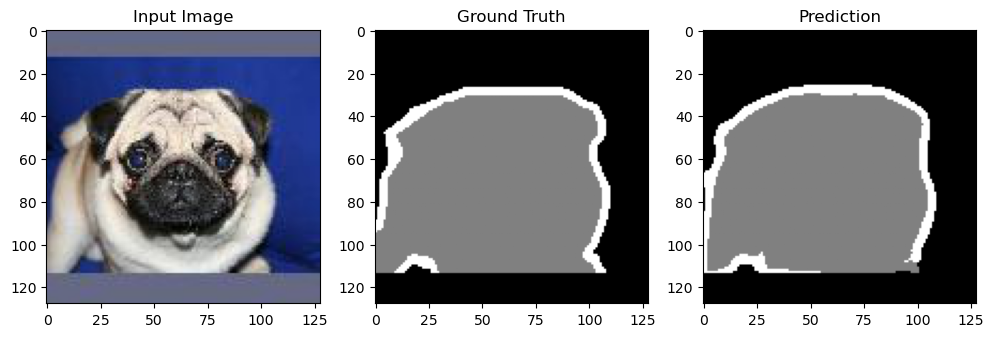

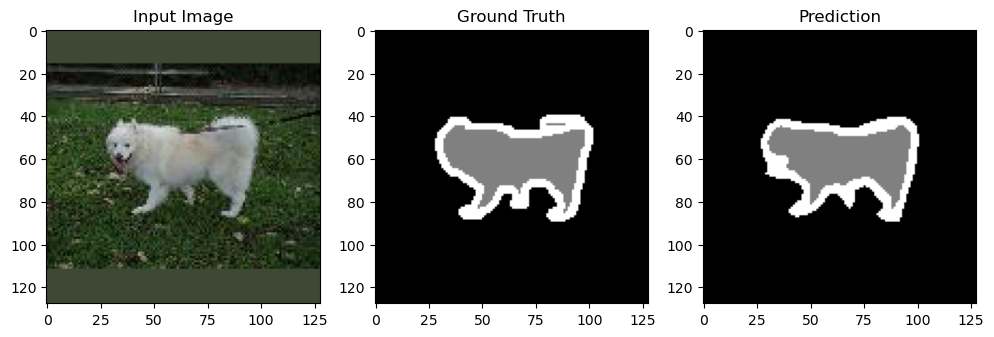

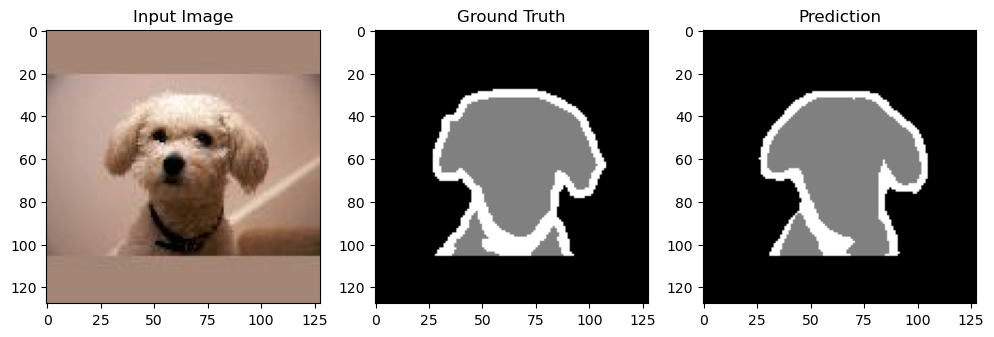

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle

#############################
#      Testing Function     #
#############################


class SegmentationDatasetWithText(Dataset):
    """
    Extends SegmentationDataset to also return token IDs extracted from the filename.
    The tokenization procedure matches the one used in build_vocabulary:
      - The first token (lowercased) is taken as the animal type.
      - All subsequent tokens (lowercased) before the first digit are joined with '_' to form the breed name.
    """
    def __init__(self, root_dir, vocab, max_tokens=2, transform_img=None, transform_label=None):
        self.root_dir = Path(root_dir)
        self.color_dir = self.root_dir / "color"
        self.label_dir = self.root_dir / "label"
        self.vocab = vocab
        self.max_tokens = max_tokens  # desired fixed length of the token sequence
        self.transform_img = transform_img
        self.transform_label = transform_label

        self.image_files = sorted([
            f for f in self.color_dir.iterdir()
            if f.is_file() and f.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])

    def tokenize_filename(self, filename):
        # Remove file extension.
        base = filename.rsplit(".", 1)[0]
        tokens = base.split("_")
        # The first token (lowercased) is the animal type.
        animal_type = tokens[0].lower()
        # For the breed, gather all tokens (from the second token on) until a number is encountered.
        breed_tokens = []
        for tok in tokens[1:]:
            if tok.isdigit():
                break
            breed_tokens.append(tok.lower())
        # Join the breed tokens with underscore.
        breed_name = "_".join(breed_tokens)
        
        # Build the list of token IDs based on the vocabulary.
        token_ids = []
        # Get the ID for the animal type.
        token_ids.append(self.vocab.get(animal_type, 0))
        # Get the ID for the breed name.
        token_ids.append(self.vocab.get(breed_name, 0))
        
        # If you want to pad to max_tokens length (e.g., 5 tokens), do so:
        if len(token_ids) < self.max_tokens:
            token_ids += [0] * (self.max_tokens - len(token_ids))
        else:
            token_ids = token_ids[:self.max_tokens]
        
        return token_ids

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        label_path = self.label_dir / (img_path.stem + ".png")
        label = Image.open(label_path).convert("L")
        
        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)
        
        label_np = np.array(label, dtype=np.int64)
        label_new = np.zeros_like(label_np)
        label_new[label_np == 38] = 1
        label_new[label_np == 75] = 1
        label_new[label_np == 255] = 2
        label_tensor = torch.from_numpy(label_new).long()
        if self.transform_label:
            label_tensor = self.transform_label(label_tensor)
        
        token_ids = self.tokenize_filename(img_path.name)
        token_ids_tensor = torch.tensor(token_ids, dtype=torch.long)
        
        return image, label_tensor, token_ids_tensor

# --- Load the vocabulary from the pickle file instead of rebuilding it ---
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
print("Loaded vocabulary, size:", len(vocab)+1)
print("Vocabulary:", vocab)

# Define transforms.
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

# Create the test dataset that returns images and token IDs.
test_dataset = SegmentationDatasetWithText(
    root_dir="./Dataset/processed/Test",
    vocab=vocab,
    max_tokens=5,  # or your desired fixed length
    transform_img=test_transform,
    transform_label=None
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Instantiate your CLIP segmentation model.
# (Ensure that your model class is defined and imported.)
vocab_size = len(vocab)+1
model = ImprovedCLIPSegmentationModel(
    vocab_size=vocab_size,
    text_embed_dim=128,
    text_output_dim=512,
    image_embed_channels=512,
    num_classes=3,
    dropout_prob=0.25
)

# Load the saved checkpoint.
checkpoint_path = "clip_segmentation_best.pth"
state_dict = torch.load(checkpoint_path, map_location=torch.device("mps"))
model.load_state_dict(state_dict)
model.eval()

# Define a loss function for evaluation.
criterion = nn.CrossEntropyLoss()

# Run the test loop using the test dataset with real token IDs.
running_loss = 0.0
running_correct = 0
total_pixels = 0
all_preds = []
all_masks = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for images, masks, token_ids in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        token_ids = token_ids.to(device)
        
        outputs = model(images, token_ids)  # [B, 3, 128, 128]
        loss = criterion(outputs, masks)
        running_loss += loss.item() * images.size(0)
        
        preds = torch.argmax(outputs, dim=1)
        running_correct += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)
        
        all_preds.append(preds.cpu())
        all_masks.append(masks.cpu())

test_loss = running_loss / len(test_dataset)
test_acc = running_correct / total_pixels

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Optionally compute IoU.
def compute_iou(preds, targets, num_classes=3):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

all_preds = torch.cat(all_preds, dim=0)
all_masks = torch.cat(all_masks, dim=0)
ious = compute_iou(all_preds, all_masks, num_classes=3)
avg_iou = np.nanmean(ious)
print(f"Test IoU: {avg_iou:.4f}")

# Visualization: Show a few test images with their predictions.
num_samples = 3
sample_indices = random.sample(range(len(test_dataset)), num_samples)
for idx in sample_indices:
    image, mask, token_ids = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device), token_ids.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(image.permute(1,2,0))
    plt.title("Input Image")
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=2)
    plt.title("Ground Truth")
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray', vmin=0, vmax=2)
    plt.title("Prediction")
    plt.show()

Loaded vocabulary, size: 39
Vocabulary: {'abyssinian': 1, 'american_bulldog': 2, 'american_pit_bull_terrier': 3, 'basset_hound': 4, 'beagle': 5, 'bengal': 6, 'birman': 7, 'bombay': 8, 'boxer': 9, 'british_shorthair': 10, 'chihuahua': 11, 'egyptian_mau': 12, 'english_cocker_spaniel': 13, 'english_setter': 14, 'german_shorthaired': 15, 'great_pyrenees': 16, 'havanese': 17, 'japanese_chin': 18, 'keeshond': 19, 'leonberger': 20, 'maine_coon': 21, 'miniature_pinscher': 22, 'newfoundland': 23, 'persian': 24, 'pomeranian': 25, 'processed': 26, 'pug': 27, 'ragdoll': 28, 'russian_blue': 29, 'saint_bernard': 30, 'samoyed': 31, 'scottish_terrier': 32, 'shiba_inu': 33, 'siamese': 34, 'sphynx': 35, 'staffordshire_bull_terrier': 36, 'wheaten_terrier': 37, 'yorkshire_terrier': 38}
Test Loss: 0.3656
Test Accuracy: 0.8652
Test IoU: 0.6156


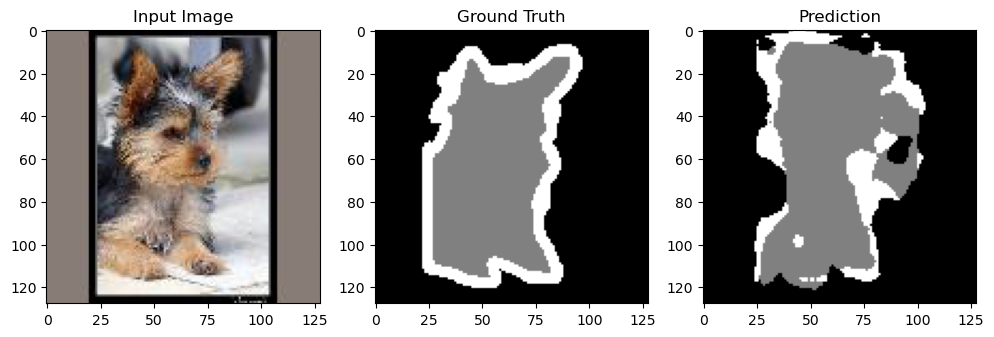

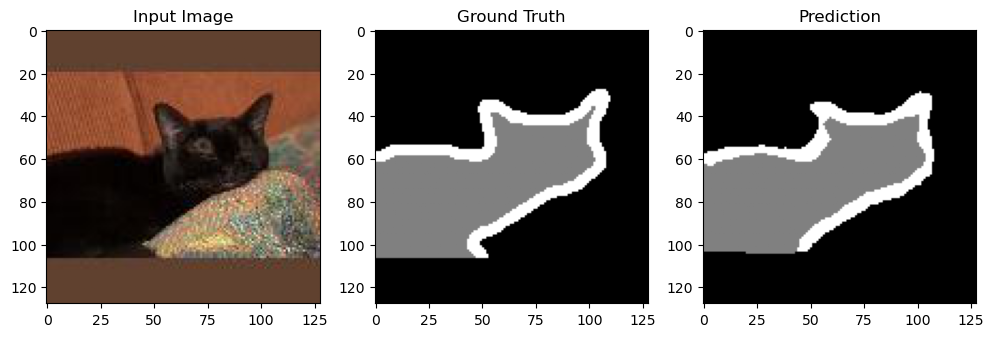

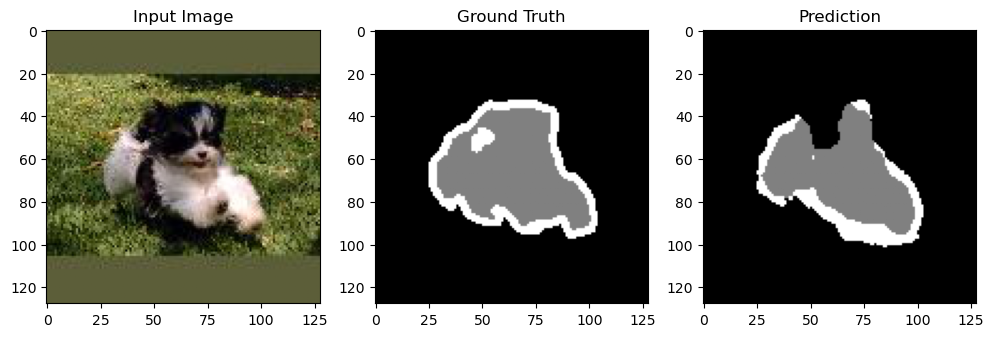

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle

# --- Your SegmentationDatasetWithText class ---
class SegmentationDatasetWithText(Dataset):
    """
    Extends SegmentationDataset to also return token IDs extracted from the filename.
    The tokenization procedure matches the one used in build_vocabulary:
      - The first token (lowercased) is taken as the animal type.
      - All subsequent tokens (lowercased) before the first digit are joined with '_' to form the breed name.
    """
    def __init__(self, root_dir, vocab, max_tokens=2, transform_img=None, transform_label=None):
        self.root_dir = Path(root_dir)
        self.color_dir = self.root_dir / "color"
        self.label_dir = self.root_dir / "label"
        self.vocab = vocab
        self.max_tokens = max_tokens  # desired fixed length of the token sequence
        self.transform_img = transform_img
        self.transform_label = transform_label

        self.image_files = sorted([
            f for f in self.color_dir.iterdir()
            if f.is_file() and f.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])

    def tokenize_filename(self, filename):
        # Remove file extension.
        base = filename.rsplit(".", 1)[0]
        tokens = base.split("_")
        # The first token (lowercased) is the animal type.
        animal_type = tokens[0].lower()
        # For the breed, gather all tokens (from the second token on) until a number is encountered.
        breed_tokens = []
        for tok in tokens[1:]:
            if tok.isdigit():
                break
            breed_tokens.append(tok.lower())
        # Join the breed tokens with underscore.
        breed_name = "_".join(breed_tokens)
        
        # Build the list of token IDs based on the vocabulary.
        token_ids = []
        token_ids.append(self.vocab.get(animal_type, 0))
        token_ids.append(self.vocab.get(breed_name, 0))
        if len(token_ids) < self.max_tokens:
            token_ids += [0] * (self.max_tokens - len(token_ids))
        else:
            token_ids = token_ids[:self.max_tokens]
        return token_ids

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        label_path = self.label_dir / (img_path.stem + ".png")
        label = Image.open(label_path).convert("L")
        
        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)
        
        label_np = np.array(label, dtype=np.int64)
        label_new = np.zeros_like(label_np)
        label_new[label_np == 38] = 1
        label_new[label_np == 75] = 1
        label_new[label_np == 255] = 2
        label_tensor = torch.from_numpy(label_new).long()
        if self.transform_label:
            label_tensor = self.transform_label(label_tensor)
        
        token_ids = self.tokenize_filename(img_path.name)
        token_ids_tensor = torch.tensor(token_ids, dtype=torch.long)
        
        return image, label_tensor, token_ids_tensor

# --- Load the vocabulary from the pickle file (saved during training) ---
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
print("Loaded vocabulary, size:", len(vocab)+1)
print("Vocabulary:", vocab)

# --- Define transforms ---
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

# --- Create the test dataset using the dataset that returns token IDs ---
test_dataset = SegmentationDatasetWithText(
    root_dir="./Dataset/processed/Test",
    vocab=vocab,
    max_tokens=2,  # Use the same max_tokens as during training
    transform_img=test_transform,
    transform_label=None
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- Instantiate your model (ImprovedCLIPSegmentationModel) ---
vocab_size = len(vocab) + 1  # because index 0 is reserved for padding
model = ImprovedCLIPSegmentationModel(
    vocab_size=vocab_size,
    text_embed_dim=128,
    text_output_dim=512,
    image_embed_channels=512,
    num_classes=3,
    dropout_prob=0.25
)

# --- Load the saved checkpoint ---
checkpoint_path = "clip_segmentation_best3.pth"
state_dict = torch.load(checkpoint_path, map_location=torch.device("mps"))
model.load_state_dict(state_dict)
model.eval()

# --- Evaluation loop ---
criterion = nn.CrossEntropyLoss()

running_loss = 0.0
running_correct = 0
total_pixels = 0
all_preds = []
all_masks = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for images, masks, token_ids in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        token_ids = token_ids.to(device)
        
        outputs = model(images, token_ids)  # Model receives both images and token IDs
        loss = criterion(outputs, masks)
        running_loss += loss.item() * images.size(0)
        
        preds = torch.argmax(outputs, dim=1)
        running_correct += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)
        
        all_preds.append(preds.cpu())
        all_masks.append(masks.cpu())

test_loss = running_loss / len(test_dataset)
test_acc = running_correct / total_pixels

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

def compute_iou(preds, targets, num_classes=3):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

all_preds = torch.cat(all_preds, dim=0)
all_masks = torch.cat(all_masks, dim=0)
ious = compute_iou(all_preds, all_masks, num_classes=3)
avg_iou = np.nanmean(ious)
print(f"Test IoU: {avg_iou:.4f}")

# --- Visualization ---
import random
num_samples = 3
sample_indices = random.sample(range(len(test_dataset)), num_samples)
for idx in sample_indices:
    image, mask, token_ids = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device), token_ids.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(image.permute(1,2,0))
    plt.title("Input Image")
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=2)
    plt.title("Ground Truth")
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray', vmin=0, vmax=2)
    plt.title("Prediction")
    plt.show()